In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [2]:
BASE_DIR='./'
WORKING_DIR='./'

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


Extract Image Features

In [4]:
model=VGG16()


In [5]:
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)

In [6]:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [7]:
features={}
directory=os.path.join(BASE_DIR,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path=directory+ '/'+img_name
    image=load_img(img_path,target_size=(224,224))
    # convert to array
    image=img_to_array(image)
    # reshape data
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    # preprocess for VGG model
    image=preprocess_input(image)
    # extract features
    feature=model.predict(image,verbose=0)
    # img ID
    img_id= img_name.split('.')[0]
    features[img_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [8]:
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [9]:
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features=pickle.load(f)

In [10]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    # to skip first line
    next(f)
    captions_doc=f.read()

In [11]:
# map img to caption
mapping={}
for line in tqdm(captions_doc.split('\n')):
    tokens= line.split(',')
    if len(line)<2:
        continue
    img_id,caption=tokens[0],tokens[1:]
    img_id=img_id.split('.')[0]
    # convert list to string
    caption=" ".join(caption)
    # create list if needed
    if img_id not in mapping:
        mapping[img_id]=[]
    mapping[img_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

PREPROCESS DATA


In [12]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            # one caption at a time
            caption=captions[i]
            # preprocessing
            # convert to lowercase
            caption=caption.lower()
            # replace digits, special chars etc
            caption=caption.replace('[^A-Za-z]','')
            caption=caption.replace('\s+', ' ')
            # for seq-to-seq model add start and end tags
            caption='startseq' + " ".join([word for word in caption.split() if len(word)>1]) + 'endseq'
            captions[i]=caption

In [13]:
clean(mapping)

In [14]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
# tokenize text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index) + 1

In [16]:
# get max length of caption
max_length=max(len(caption.split()) for caption in all_captions)
max_length

33

Train_Test_Split

In [17]:
image_ids = list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]

In [18]:
# create data generator for batch training
def data_gen(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    X1,X2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            for caption in captions:
                # encode
                seq=tokenizer.texts_to_sequences([caption])[0]
                # split seq into X,y pairs
                for i in range(1,len(seq)):
                    # split into i/p and o/p
                    in_seq,out_seq=seq[:i],seq[i]
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                X1,X2,y=list(),list(),list()
                n=0
                

MODEL

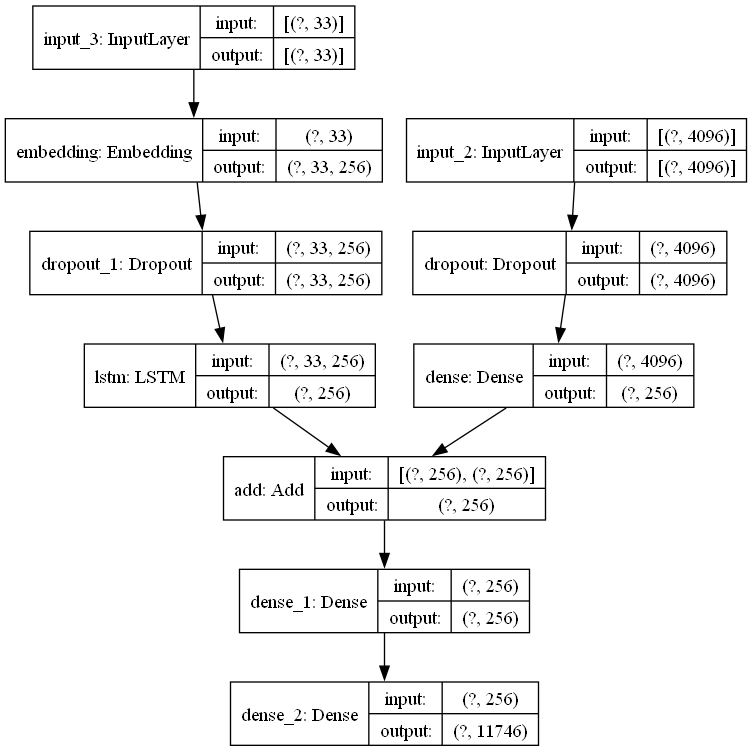

In [19]:
# Encoder Model
# img feature layers
inputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)

# seq feature layers
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)

# Decoder Model
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model =Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

# plot
plot_model(model,show_shapes=True)

In [20]:
epochs=20
batch_size=64
steps=len(train)//batch_size
for i in range(epochs):
    generator=data_gen(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

113/113 [==============================] - 181s 2s/step - loss: 2.3537


In [21]:
model.save('image_captioning_model.h5')

generate captions for img


In [22]:
def index_to_word(integer, tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [23]:
def predict_caption(model,image,tookenizer,max_length):
    in_text='startseq'
    # iterate over max leength
    for i in range(max_length):
        # encode i/p
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence])
        yhat=model.predict([image,sequence],verbose=0)
        # get index w high probability
        yhat=np.argmax(yhat)
        # convert index to word
        word=index_to_word(yhat,tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input
        in_text+= ' '+word
        # stop if we reach end tag
        if word=='endseq':
            break
    return in_text

In [24]:
from nltk.translate.bleu_score import corpus_bleu
actual,predicted=list(),list()
for key in tqdm(test):
    captions=mapping[key]
    # predict caption
    y_pred=predict_caption(model,features[key],tokenizer,max_length)
    # split into words
    y_pred=y_pred.split()
    actual_captions=[caption.split() for caption in captions]
    # appendddddd
    actual.append(actual_captions)
    predicted.append(y_pred)

print(f"BLEU-1:{corpus_bleu(actual,predicted,weights=(1.0,0,0,0))}")
print(f"BLEU-1:{corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0))}")

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1:0.2692683660425596
BLEU-1:0.1347363817314442


Visualize results

In [25]:
from PIL import Image
import matplotlib.pyplot as plt


In [26]:
# load img
def generate_caption(image_name):
    image_id=image_name.split('.')[0]
    image_path=os.path.join(BASE_DIR,"Images",image_name)
    image=Image.open(image_path)
    captions=mapping[image_id]
    print("---------Actual------------")
    for caption in captions:
        print(caption)
    y_pred=predict_caption(model,features[image_id],tokenizer,max_length)
    print("-------------Predicted---------------")
    print(y_pred)
    plt.imshow(image)

---------Actual------------
startseqgroup of people are sitting around campfire at nightendseq
startseqgroup of people sitting on the grass by fire at nighttimeendseq
startseqgroup of young people are sitting around fire pitendseq
startseqfriends enjoy campfireendseq
startseqseveral people sitting around campfireendseq
-------------Predicted---------------
startseq two children in red and white are gathered around fire endseq


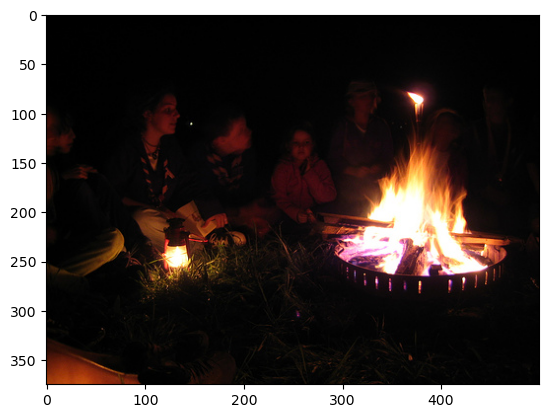

In [28]:
generate_caption("69710411_2cf537f61f.jpg")